# Factorization Machines 

A downside of MF is that it is simply a matrix decomposition framework. As such, we can only represent the matrix as a *user-item* matrix and unable to incorporate side features such as movie genre, language, etc. The factorization process has to learn all these from existing interactions. Hence, factorization machines are introduced as an improved version of MF.

Factorization machines (FM) is a supervised algorithm that can be used for classification, regression, and ranking tasks. Particularly, it is a generalization of the linear regression model and the matrix factorization model. Moreover, it is reminiscent of support vector machines with a polynomial kernel.

FM is formulated as a linear model, with interactions between features as additional parameters (features). However, these user/item indicators can be augmented with arbitrary auxiliary features, for example, user or item attributes and/or contextual features relevant to the interaction itself. These feature interactions are done in their latent space representation instead of their plain format.

![](https://drive.google.com/uc?id=1-1ywT0sOGrYs8lXJ-zljSrF2mF6gQxvS)

* A linear model, given a vector *x* models its output *y* as: 

  ![](https://drive.google.com/uc?id=1U1HUGuROvvxHQ-abyJHx5HgoQvd7ExDD)
  
  where *w* are the learnable weights of the model.

* The model for a factorization machine of degree two is defined as:
![](https://drive.google.com/uc?id=1W_ndd8TORVF_3zFk40wNifBPZYtPP0jo)

* However, this introduces a large number of *w2* variables. This equiation can be  re-formulation as low-rank re-formulation to reduce the number of additional parameters for the factorization machine.

  ![](https://drive.google.com/uc?id=1L9cx5gghNPaf_FpTCWj6EwhS6--FhAMg)

  The first two terms correspond to the linear regression model and the last term is an extension of the matrix factorization model. If the feature *i*  represents an item and the feature *j*  represents a user, the third term is exactly the dot product between user and item embeddings. 

# Model implementation in PyTorch

In [1]:
# import libraries
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
# Initialize a Loader class
class Loader():
    # Set the iterator
    current = 0

    def __init__(self, x, y, batchsize=1024, do_shuffle=True):
        """
        :param x: features
        :param y: target
        :param batchsize: batch size = 1024
        :param do_shuffle: shuffle mode turned on
        """
        self.shuffle = shuffle
        self.x = x
        self.y = y
        self.batchsize = batchsize
        self.batches = range(0, len(self.y), batchsize)
        if do_shuffle:
            # Every epoch re-shuffle the dataset
            self.x, self.y = shuffle(self.x, self.y)

    def __iter__(self):
        # Reset & return a new iterator
        self.x, self.y = shuffle(self.x, self.y, random_state=0)
        self.current = 0
        return self

    def __len__(self):
        # Return the number of batches
        return int(len(self.x) / self.batchsize)

    def __next__(self):
        # Update iterator and stop iteration until the batch size is out of range
        n = self.batchsize
        if self.current + n >= len(self.y):
            raise StopIteration
        i = self.current

        # Transform NumPy arrays to PyTorch tensors
        xs = torch.from_numpy(self.x[i:i + n])
        ys = torch.from_numpy(self.y[i:i + n])
        self.current += n
        return xs, ys
    
def index_into(arr, idx):
    new_shape = (idx.size()[0], idx.size()[1], arr.size()[1])
    return arr[idx.resize(torch.numel(idx.data))].view(new_shape)

We can reorganize the third term of FM which could greatly reduce the computation cost, leading to a linear time complexity. The reformulation of the pairwise interaction term is as follows:


In [4]:
def factorization_machine(v, x=None):
    """
    Takes an input 2D matrix v of n vectors, each d-dimensional
    :param v: (batchsize, n_features, dim)
    :param x: (batchsize, n_features) functions as a weight array, assumed to be 1 if missing
    :return: output that is d-dimensional
    """
    batchsize = v.size()[0]
    n_features = v.size()[1]
    n_dim = v.size()[2]

    if x is None:
        x = Variable(torch.ones(v.size()))
    else:
        x = x.expand(batchsize, n_features, n_dim)

    # Uses Rendle's trick for computing pairs of features in linear time
    t0 = (v * x).sum(dim=1) ** 2.0
    t1 = (v ** 2.0 * x ** 2.0).sum(dim=1)
    return 0.5 * (t0 - t1)

In [6]:
class FM(nn.Module):
    # Iteration counter
    itr = 0

    def __init__(self, n_feat, k=10, c_feat=1.0, c_bias=1.0, writer=None):
        """
        :param n_feat: Feature column
        :param k: Dimensions constant
        :param c_feat: Regularization constant for the features
        :param c_bias: Regularization constant for the biases
        :param writer: Log results via TensorBoard
        """
        super(FM, self).__init__()

        # This will hold the logging
        self.writer = writer

        # These are the hyper-parameters
        self.k = k
        self.n_feat = n_feat
        self.c_feat = c_feat
        self.c_bias = c_bias

        # The embedding matrices for the features and the feature's biases
        self.feat = nn.Embedding(n_feat, k)
        self.bias_feat = nn.Embedding(n_feat, 1)

    def __call__(self, train_x):
        """This is the most important function in this script"""
        # Pull out biases
        biases = index_into(self.bias_feat.weight, train_x).squeeze().sum(dim=1)

        # Initialize vector features using the feature weights
        vector_features = index_into(self.feat.weight, train_x)

        # Use factorization machines to pull out the interactions
        interactions = factorization_machine(vector_features).squeeze().sum(dim=1)

        # Final prediction is the sum of biases and interactions
        prediction = biases + interactions
        return prediction

    def loss(self, prediction, target):
        """
        Function to calculate the loss metric
        """
        # Calculate the Mean Squared Error between target and prediction
        loss_mse = F.mse_loss(prediction.squeeze(), target.squeeze())

        # Compute L2 regularization over feature matrices
        prior_feat = l2_regularize(self.feat.weight) * self.c_feat

        # Add the MSE loss and feature regularization to get total loss
        total = (loss_mse + prior_feat)

        # This logs all local variables to tensorboard
        for name, var in locals().items():
            if type(var) is torch.Tensor and var.nelement() == 1 and self.writer is not None:
                self.writer.add_scalar(name, var, self.itr)
        return total

def l2_regularize(array):
    """
    Function to do L2 regularization
    """
    loss = torch.sum(array ** 2.0)
    return loss

In [ ]:
# get the data
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

In [10]:
# read the data
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', engine='python', 
                      names=('userId', 'movieId','ratings','timestamp'))

# Create users dataframe
users = pd.read_csv("./ml-1m/users.dat", sep='::', engine='python',
                    names=['userId', 'gender', 'age', 'occupation', 'zipcode'])

# Create users dataframe
movies = pd.read_csv("./ml-1m/movies.dat", sep='::', engine='python',
                    names=['movieId', 'title', 'genres_str'])

# Is this rating the first rating ever for that user, or the nth?
ratings['rank'] = ratings.groupby("userId")["timestamp"].rank(ascending=True).astype('int64')

# Merge ratings & user features
dataset = ratings.merge(users, on='userId')
dataset = dataset.merge(movies, on='movieId')
dataset = dataset.sample(frac=1)
dataset.drop(columns=['timestamp', 'zipcode', 'title', 'genres_str'], inplace=True)
dataset['gender'] = dataset['gender'].map({'M':0, 'F':1})
assert len(ratings) == len(dataset)

# Compute cardinalities
n_user = dataset.userId.max() + 1
n_item = dataset.movieId.max() + 1
n_rank = dataset['rank'].max() + 1
n_age = dataset['age'].max() + 1
n_occu = dataset['occupation'].max() + 1
n_gen = dataset['gender'].nunique()
n_feat = n_user + n_item + n_rank + n_age + n_occu + n_gen

print('n_user', n_user)
print('n_item', n_item)
print('n_rank', n_rank)
print('n_gen', n_gen)
print('n_age', n_age)
print('n_occu', n_occu)
print('n_feat', n_feat)
print('n_rows', len(dataset))

display(dataset.head())

n_user 6041
n_item 3953
n_rank 2315
n_gen 2
n_age 57
n_occu 21
n_feat 12389
n_rows 1000209


,userId,movieId,ratings,rank,gender,age,occupation
403484,3540,1356,4,182,0,18,17
68098,3182,1103,4,555,0,25,12
719345,5468,3052,3,10,0,25,12
115605,5511,1084,5,69,0,45,1
924253,1926,2929,4,361,1,1,0


In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# split the dataset into training and testing datasets
train_df, test_df = train_test_split(dataset, test_size=0.1)

train_df.loc[:, 'movieId'] = n_user
train_df.loc[:, 'rank'] = n_user + n_item
train_df.loc[:, 'gender'] = n_user + n_item + n_rank
train_df.loc[:, 'age'] = n_user + n_item + n_rank + n_gen
train_df.loc[:, 'occupation'] = n_user + n_item + n_rank + n_gen + n_age

test_df.loc[:, 'movieId'] = n_user
test_df.loc[:, 'rank'] = n_user + n_item
test_df.loc[:, 'gender'] = n_user + n_item + n_rank
test_df.loc[:, 'age'] = n_user + n_item + n_rank + n_gen
test_df.loc[:, 'occupation'] = n_user + n_item + n_rank + n_gen + n_age

train_X = torch.tensor(train_df[['userId', 'movieId', 'rank', 'gender', 'age', 'occupation']].values)
train_y = torch.FloatTensor(train_df['ratings'].values)
test_x = torch.tensor(test_df[['userId', 'movieId', 'rank', 'gender', 'age', 'occupation']].values)
test_y = torch.FloatTensor(test_df['ratings'].values)

train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=1024)
test_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=1024)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [12]:
losses = []

def fit(model, epochs, dataloader, optimizer):
    model.train()
    for epoch in range(epochs):
        for batch in dataloader:
            optimizer.zero_grad()
            x, y = batch[0], batch[1]
            y_pred = model(x)
            loss = model.loss(y_pred, y)
            loss.backward()
            optimizer.step()
        print(f"epoch {epoch}'s training loss %.3f" % loss.item())
        losses.append(loss.data.numpy())

def evaluate(model, dataloader):
    model.eval()
    for batch in dataloader:
        with torch.no_grad():
            x, y = batch[0], batch[1]
            y_pred = model(x)
            loss = model.loss(y_pred, y)
    print("test loss %.3f " % loss.item())
    # return y_pred, y

In [13]:
# Define the Hyper-parameters
lr = 1e-2  # Learning rate
k = 10  # Number of dimensions per user and item
c_bias = 1e-6  # Bias constant
c_feat = 1e-6  # Regularization constant

# Instantiate the model class object
model = FM(n_feat, k=k, c_bias=c_bias, c_feat=c_feat)

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

fit(model, epochs=10, dataloader=train_loader, optimizer=optimizer)
evaluate(model, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


epoch 0's training loss 1.345
epoch 1's training loss 1.155
epoch 2's training loss 1.121
epoch 3's training loss 1.086
epoch 4's training loss 1.057
epoch 5's training loss 1.035
epoch 6's training loss 1.016
epoch 7's training loss 0.998
epoch 8's training loss 0.989
epoch 9's training loss 0.957
test loss 1.053 


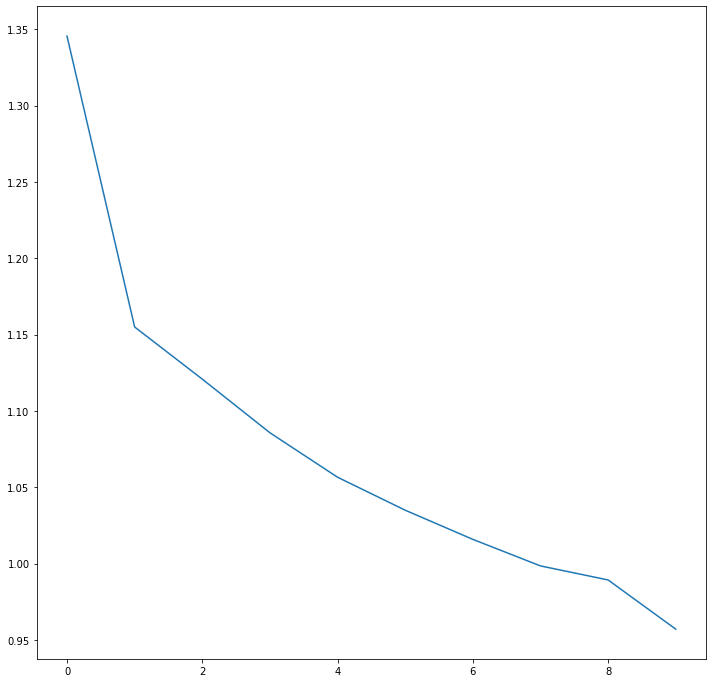

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
n = len(losses)
smooth = np.convolve(losses, np.ones((n,))/n, mode='valid')
plt.figure(figsize=(12, 12))
plt.plot(losses)
plt.plot(smooth, c='r')

# Make predictions